# CNTK_206A: Time series prediction with LSTM
This notebook demonstrates how to use CNTK to predict future values in a time series.
We will use a [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) to implement our model. For details on how LSTMs work, see [this excellent posts](http://colah.github.io/posts/2015-08-Understanding-LSTMs).

The task we want to accomplish in our example: 

Based on N subsequent values of a continues function (we use sin(x) as example) we want to predict a future value M steps out.

LSTMs are well suited for this task because their ability to learn from experience.

We setup our network with 1 LSTM cell for each input. We have N inputs and each input is a value in our continues function. The N outputs from the LSTM are the input into a dense layer that produces a single output. 
Between LSTM and dense layer we insert a dropout layer that randomly drops 20% of the values coming the LSTM to prevent overfitting the model to the training dataset. We want use use the dropout layer during training but when using the model to make predictions we don't want to drop values.
![lstm](https://guschmueds.blob.core.windows.net/datasets/1.png)

This model works for lots real world data. In part A of this tuturial we use a simple sin(x) function and in part B of the tutorial we'll use real data and try to predict daily output of solar pannel. 

Using CNTK we can easily express our model:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math
import pandas as pd
import time

import cntk
import cntk.layers
import cntk.models

N = 5 # input: N subsequent values 
M = 5 # output: predict 1 value M steps ahead

TRAINING_STEPS = 10000
BATCH_SIZE = 100
EPOCHS = 200 

def lstm_model(x):
    """Create the model for time series prediction"""
    with cntk.layers.default_options(initial_state=0.1):
        m = cntk.layers.Recurrence(cntk.layers.LSTM(N))(x)
        m = cntk.ops.sequence.last(m)
        m = cntk.layers.Dropout(0.2)(m)
        m = cntk.layers.Dense(1)(m)
        return m

We need a few methods to generate the data. 

Assuming N=5, M=5, generate_data() will generate the desired sin wave and returns numpy arrrays in the following shape:

```
# the input to the lstm
X = [
 [[y0],[y1],[y2],[y3],[y4], ...],
 [[y1],[y2],[y3],[y4],[y5], ...],
 ...
]

# the desired output, M(=5) steps in the future
Y = [
  [y4+5],
  [y5+5]
  ...
]
```

split_data() will split the data into training, validation and test sets.

In [2]:
def split_data(data, val_size=0.1, test_size=0.1):
    """
    splits np.array into training, validation and test
    """
    pos_test = int(len(data) * (1 - test_size))
    pos_val = int(len(data[:pos_test]) * (1 - val_size))

    train, val, test = data[:pos_val], data[pos_val:pos_test], data[pos_test:]

    return {"train": train, "val": val, "test": test}


def generate_data(fct, x, time_steps, time_shift):
    """
    generate sequences to feed to rnn for fct(x)
    """
    data = fct(x)
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(dict(a=data[0:len(data) - time_shift],
                                 b=data[time_shift:]))
    rnn_x = []
    for i in range(len(data) - time_steps):
        rnn_x.append(data['a'].iloc[i: i + time_steps].as_matrix())
    rnn_x = np.array(rnn_x)
    rnn_x = rnn_x.reshape(rnn_x.shape + (1,))
    rnn_y = data['b'].values
    rnn_y = rnn_y.reshape(rnn_y.shape + (1,))

    return split_data(rnn_x), split_data(rnn_y)


X, Y = generate_data(np.sin, np.linspace(0, 100, 10000, dtype=np.float32), N, M)

We define the next_batch() iterator that produces batches we can feed to the training function. 
Note that because CNTK supports variable sequence length, we must feed the batches as list of sequences.

In [3]:
def next_batch(x, y, ds):
    """get the next batch to process"""

    def as_batch(data, start, count):
        part = []
        for i in range(start, start + count):
            part.append(data[i])
        return np.array(part)

    for i in range(0, len(x[ds])-BATCH_SIZE, BATCH_SIZE):
        yield as_batch(x[ds], i, BATCH_SIZE), as_batch(y[ds], i, BATCH_SIZE)

Setup everything else we need for training the model: define inputs, outputs, model and the optimizer.

In [4]:
# tell cntk that we use dynamic axis
x_axes = [cntk.Axis.default_batch_axis(), cntk.Axis.default_dynamic_axis()]
y_axes = [cntk.Axis.default_batch_axis()]

# input sequences
x = cntk.input_variable((1), np.float32, dynamic_axes=x_axes, name="x")

# expected output
y = cntk.input_variable((1), np.float32, dynamic_axes=y_axes, name="y")

# create the model
z = lstm_model(x)

# the learning rate
learning_rate = 0.001
lr_schedule = cntk.learning_rate_schedule(learning_rate, cntk.UnitType.minibatch)

# loss function
loss = cntk.ops.squared_error(z, y)
# use msre to determin error for now
error = cntk.ops.squared_error(z, y)

# use adam optimizer
momentum_time_constant = cntk.learner.momentum_as_time_constant_schedule(BATCH_SIZE / -math.log(0.9)) 
learner = cntk.learner.adam_sgd(z.parameters, lr=lr_schedule, momentum=momentum_time_constant)
trainer = cntk.Trainer(z, loss, error, [learner])

We are ready to train. 100 epochs should yield acceptable results.

In [5]:
# train
loss_summary = []
start = time.time()
for epoch in range(0, EPOCHS):
    for x1, y1 in next_batch(X, Y, "train"):
        trainer.train_minibatch({x: x1, y: y1})
    if epoch % (EPOCHS / 10) == 0:
        training_loss = cntk.utils.get_train_loss(trainer)
        loss_summary.append(training_loss)
        print("epoch: {}, loss: {:.5f}".format(epoch, training_loss))

print("training took {} sec".format(time.time() - start))

epoch: 0, loss: 0.54847
epoch: 20, loss: 0.10498
epoch: 40, loss: 0.06863
epoch: 60, loss: 0.03966
epoch: 80, loss: 0.05932
epoch: 100, loss: 0.04944
epoch: 120, loss: 0.04274
epoch: 140, loss: 0.03104
epoch: 160, loss: 0.05065
epoch: 180, loss: 0.02886
training took 36.34958267211914 sec


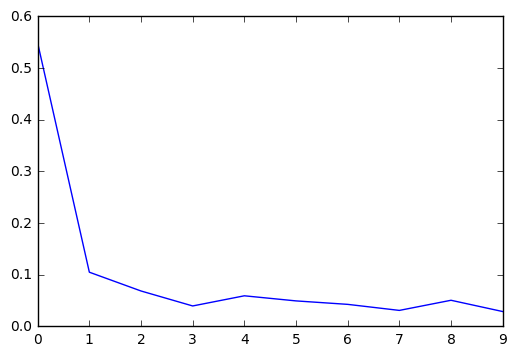

In [6]:
# A look how the loss function shows how well the model is converging
plt.plot(loss_summary, label='training loss');

Normally we would validate the training on the data that we set aside for validation but since the input data is small we can run validattion on all parts of the dataset.

In [7]:
# validate
for ds in ["train", "val", "test"]:
    result = 0.0
    for x1, y1 in next_batch(X, Y, ds):
        eval_error = trainer.test_minibatch({x: x1, y: y1})
        result += eval_error
    print("msre for {}: {:.6f}".format(ds, result / len(X[ds])))

msre for train: 0.000027
msre for val: 0.000038
msre for test: 0.000038


Since we used a simple sin(x) function we should expect that the errors are the same for train, validation and test sets. For real datasets that will be different of course.

We can also plot the expected output (Y) and the prediction our model made to shows how well the simple LSTM approach worked.

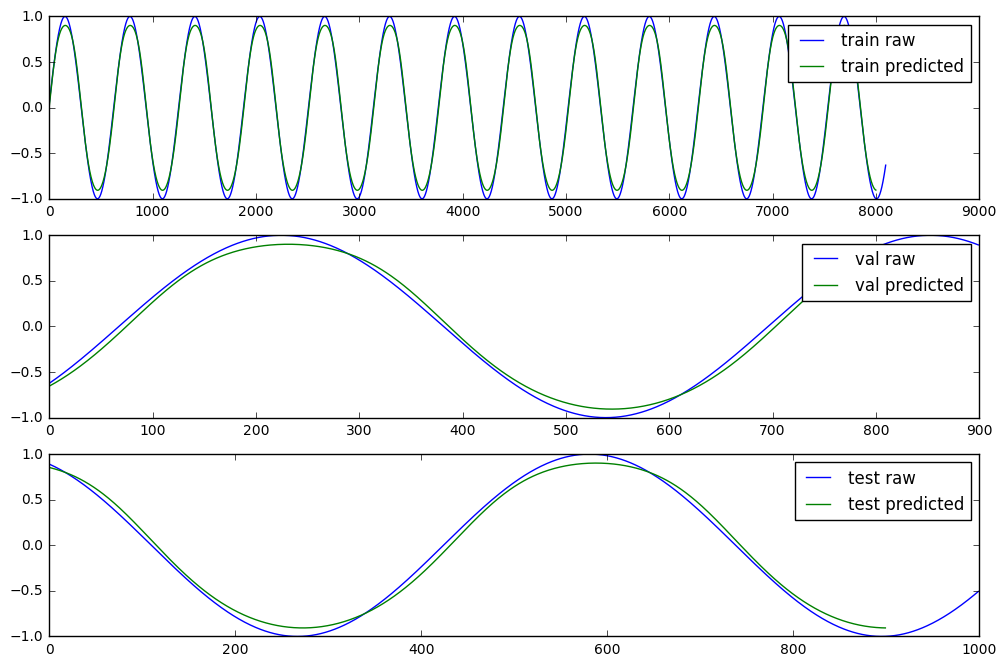

In [8]:
# predict
f, a = plt.subplots(3, 1, figsize=(12, 8))
for j, ds in enumerate(["train", "val", "test"]):
    results = []
    for x1, y1 in next_batch(X, Y, ds):
        pred = z.eval({x: x1})
        results.extend(pred[:, 0])
    a[j].plot(Y[ds], label=ds + ' raw');
    a[j].plot(results, label=ds + ' predicted');
[i.legend() for i in a];

Not perfect but close enough, considering the simplicity of the model.

Here we used a simple sin wave but you can tinker yourself and try other time series data. generate_data() allows you to pass in a dataframe with 'a' and 'b' columns instead of a function.

To improve results, we could train with more data points, let the model train for more epochs or improve on the model itself.

In [part B of this tuturial](CNTK_206B_IOT_Example_with_LSTM.ipynb) we'll use some real world data.